In [81]:
# Standard libraries

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score

## What is WAR?

From Baseball Reference: "A single number that presents the number of wins the player added to the team above what a replacement player (think AAA or AAAA) would add."

Scale for a single season: 8+ is MVP quality, 5+ is All-Star quality, 2+ is a starter and 0-2 is a bench player.

TeamWAR is the sum of the WAR for the individual players on a team. According to BR, the conversion from TeamWAR to wins is
<center> wins = TeamWAR + .294 * 162.</center>

The first objective was to verify this formula for some recent seasons and see if the wins estimate could be improved by dividing TeamWAR into contributions from position players and pitchers separately. Only data from NL teams was used, since the designated hitter leads to TeamWAR values being higher for AL teams. 

All WAR data was obtained from BR. They have WAR data for individual players and team data going back...a very long time.

In [82]:
# Import data for NL 2008-2017 seasons and drop unused columns

nl_2008_2017 = pd.read_csv('nl_2008_2017.csv')
nl_2008_2017 = nl_2008_2017[['Team', 'Year', 'Wins', 'TeamWAR', 'AllP', 'Non-P']]
nl_2008_2017.sample(10)

,Team,Year,Wins,TeamWAR,AllP,Non-P
80,ARI,2013.0,81.0,29.5,4.8,24.7
66,CHC,2012.0,61.0,16.6,5.4,11.2
62,STL,2011.0,90.0,37.0,9.6,27.4
34,CHC,2010.0,75.0,23.1,12.7,10.4
94,WSN,2013.0,86.0,31.1,14.6,16.5
33,ATL,2010.0,91.0,41.3,17.0,24.3
46,STL,2010.0,86.0,39.2,13.5,25.7
116,MIA,2015.0,71.0,25.0,6.2,18.8
107,SFG,2014.0,88.0,33.8,13.6,20.2
87,MIL,2013.0,74.0,24.6,4.4,20.2


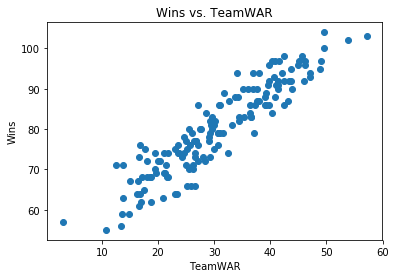

In [83]:
# Scatterplot of Wins vs TeamWAR

team_war_values = nl_2008_2017['TeamWAR']
wins_values = nl_2008_2017['Wins']

plt.scatter(team_war_values, wins_values)
plt.title('Wins vs. TeamWAR')
plt.xlabel('TeamWAR')
plt.ylabel('Wins')
plt.show()

In [84]:
# Regression line
X = pd.DataFrame(nl_2008_2017['TeamWAR'])
y = nl_2008_2017['Wins']
lm = linear_model.LinearRegression()
lm.fit(X,y)
coefficient = float(lm.coef_)
intercept = float(lm.intercept_)
print('Coefficient: ' + str(coefficient))
print('Intercept: ' + str(intercept))

Coefficient: 1.0053465398152321
Intercept: 49.41905586256729


The coefficient and intercept are similar to the standard formula from BR, where the coefficient was 1 and the intercept was 47.628. 

In [85]:
# BR model for estimating wins

def br_wins(team_war):
    return team_war + .294 * 162

In [86]:
# Data frame comparing wins and the two estimates

years = nl_2008_2017['Year']
teams = nl_2008_2017['Team']
wins = nl_2008_2017['Wins']
reg_wins_est = lm.predict(X)
br_wins_est = [br_wins(team_war) for team_war in nl_2008_2017['TeamWAR']]
wins_dic = {'Year' : years,
           'Team' : teams,
           'Wins' : wins,
           'RegWins' : reg_wins_est,
           'BRWins' : br_wins_est}
wins_df = pd.DataFrame(data = wins_dic, columns = wins_dic.keys())
wins_df.sample(5)

,Year,Team,Wins,RegWins,BRWins
73,2012.0,NYM,74.0,73.346304,71.428
35,2010.0,CIN,91.0,90.839333,88.828
45,2010.0,SFG,92.0,92.950561,90.928
94,2013.0,WSN,86.0,80.685333,78.728
53,2011.0,FLA,72.0,76.663947,74.728


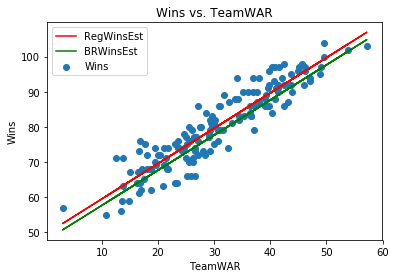

In [87]:
# Scatterplot and regression lines

team_war_values = nl_2008_2017['TeamWAR']
wins_values = nl_2008_2017['Wins']

plt.scatter(team_war_values, wins_values)
plt.plot(X, lm.predict(X), label = "RegWinsEst", color = "red")
plt.plot(team_war_values, br_wins_est, label = "BRWinsEst", color = "green")
plt.title('Wins vs. TeamWAR')
plt.xlabel('TeamWAR')
plt.ylabel('Wins')
plt.legend()
plt.show()

In [88]:
# R^2 scores

print('Regression estimate R^2 score: ' + str(r2_score(wins, reg_wins_est)))
print('BR estimate R^2 score: ' + str(r2_score(wins, br_wins_est)))

Regression estimate R^2 score: 0.855388245827
BR estimate R^2 score: 0.824675266214


In [89]:
# Separate pitching and hitting.

X_ref = nl_2008_2017.filter(['AllP', 'Non-P'], axis = 1)
y = nl_2008_2017['Wins']
lm.fit(X_ref,y)
refined_prediction = list(lm.predict(X_ref))
wins_df.insert(loc = 4, column = 'RefRegWins', value = refined_prediction)
wins_df.sample(5)

,Year,Team,Wins,RegWins,RefRegWins,BRWins
118,2015.0,NYM,90.0,87.320620,87.525595,85.328
71,2012.0,MIA,69.0,70.732403,71.191206,68.828
105,2014.0,PIT,88.0,88.728106,88.323680,86.728
8,2008.0,MIL,90.0,91.040403,90.870694,89.028
130,2016.0,LAD,91.0,89.230779,89.230233,87.228


In [90]:
# Check the refined score

print('Coefficients: ' + str(lm.coef_))
print('Intercept: ' + str(lm.intercept_))
print('Regression estimate R^2 score:')
print(r2_score(wins, refined_prediction))

Coefficients: [ 1.03221884  0.97644113]
Intercept: 49.5982102358
Regression estimate R^2 score:
0.855976953872


The score is not significantly better than the previous regression line. This suggests that the contributions from hitters and pitchers to wins is roughly the same for this period. We can also see this in the coefficients, which are both approximately equal to 1. It would be interesting to see if that has always been true, or if the eras which are sterotypically associated with dominant pitching or hitting have different trends. 